##Our Task is to find whether pokemon exist in image or not, if exist the find coordinates against real different backgrounds, pokemon has been resized by some scale and can be horizontally flipped too,only one type of pokemon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import VGG16

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2022-05-27 18:28:47--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2022-05-27 18:28:49 (58.1 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



(56, 44, 4)


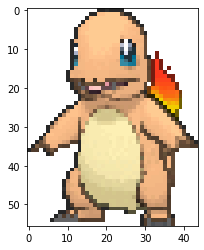

In [4]:
from imageio import imread
obj = imread('charmander-tight.png')
print(obj.shape)
plt.imshow(obj)

In [5]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip
!unzip -n backgrounds.zip

--2022-05-27 18:28:49--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  1.34MB/s    in 0.4s    

2022-05-27 18:28:50 (1.34 MB/s) - ‘backgrounds.zip’ saved [494000/494000]

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflati

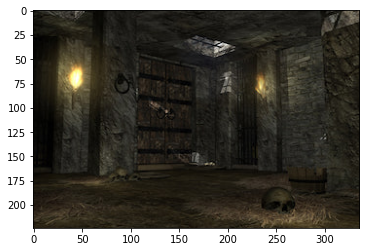

In [6]:
from glob import glob
backgrounds = []
bg_files = glob('backgrounds/*.jpg')
for bg_path in bg_files:
    bg = imread(bg_path)
    backgrounds.append(bg)

plt.imshow(backgrounds[2])

In [7]:
#Created and loaded model with input image of size (200,200,3) 
dim = 200 #pixels in image
obj_h, obj_w, _ = obj.shape
image_size = (dim,dim,3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)
x = Flatten()(vgg.output)
x = Dense(5, activation='sigmoid')(x) # first 4 node for coordinates and last node if object exists, 1 if exists 0 if not
model = tf.keras.Model(inputs=vgg.input, outputs=x)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [8]:
def get_image():
    x = np.zeros(image_size, dtype=float)  #image pixel value
    y = np.zeros(5, dtype=float)  #top-left coordinate and height and width, (row,col,height,width,isexist) within range [0,1)
    
    #Choosing random part of background of size (dim,dim,3) from list of backgrounds
    bg_id = np.random.randint(0,len(backgrounds))
    bg_h, bg_w, _ = backgrounds[bg_id].shape
    bg_r = np.random.randint(0,bg_h-dim)
    bg_c = np.random.randint(0,bg_w-dim)
    x = backgrounds[bg_id][bg_r:bg_r+dim,bg_c:bg_c+dim,:].copy()  #Assigning a slice of background, all features since it is jpg

    appear = 1
    if np.random.random() < 0.5:
        appear = 0
    
    if appear:
        #resizing the object randomly in scale of range (0.5,1.5)
        scale = 0.5+ np.random.random()
        new_h, new_w = round(scale*obj_h), round(scale*obj_w)
        char = resize(obj, (new_h,new_w), preserve_range=True).astype(np.uint8)

        #flipping the object randomly
        if np.random.random() < 0.5:
            char = np.fliplr(char)

        row0 = np.random.randint(0, dim-new_h)
        col0 = np.random.randint(0, dim-new_w)
        slice = x[row0:row0+new_h, col0:col0+new_w,:] #slicing the box where pokemon will be placed
        mask = (char[:,:,3]==0)  #assigning value 0 where pokemon pixel exist else 1
        slice = slice*np.expand_dims(mask,-1) #filtering box and choosing background where pokemon pixel doesn't exist
        slice = slice + char[:,:,:3]  #adding pokemon pixel at empty place
        x[row0:row0+new_h, col0:col0+new_w,:] = slice #assigning slice of image to resized pokemon
        y[0], y[1], y[2], y[3], y[4] = row0, col0, new_h, new_w, 1
        y[0:4] = y[0:4]/dim
    return x, y

y : [0.49  0.065 0.31  0.245 1.   ]


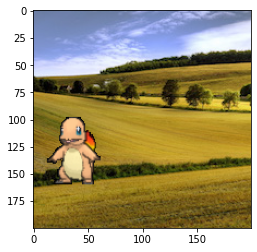

In [20]:
x,y = get_image()
print(f'y : {y}')
plt.imshow(x/255.)

In [10]:
num_batches = 50
batch_size = 64
def my_generator():
    while True:
        for _ in range(num_batches):
            X = np.zeros((batch_size,) + image_size, dtype=float)
            Y = np.zeros((batch_size, 5), dtype=float)
            for i in range(batch_size):
                X[i],Y[i] = get_image()
            yield X/255.,Y

In [11]:
#loss is defined alpha*y_true[4]*bce_point + beta*bce_exist
alpha = 2
beta = 0.5
def custom_loss(y_true, y_pred):
    #tuple of 5 points
    #(row, col, height, width, is_exist)
    bce_point = binary_crossentropy(y_true[:,0:4], y_pred[:,0:4])
    bce_exist = binary_crossentropy(y_true[:,4], y_pred[:,4])
    return alpha*y_true[:,4]*bce_point + beta*bce_exist

In [12]:
model.compile(optimizer=Adam(0.0003), loss=custom_loss, metrics='mse')
model.fit(my_generator(), epochs=10, steps_per_epoch=num_batches)

Epoch 1/10
50/50 [==============================] - 54s 655ms/step - loss: 0.8882 - mse: 0.0890
Epoch 2/10
50/50 [==============================] - 33s 663ms/step - loss: 0.5873 - mse: 0.0558
Epoch 3/10
50/50 [==============================] - 34s 674ms/step - loss: 0.5566 - mse: 0.0537
Epoch 4/10
50/50 [==============================] - 34s 685ms/step - loss: 0.5598 - mse: 0.0513
Epoch 5/10
50/50 [==============================] - 34s 690ms/step - loss: 0.5433 - mse: 0.0502
Epoch 6/10
50/50 [==============================] - 35s 694ms/step - loss: 0.5271 - mse: 0.0531
Epoch 7/10
50/50 [==============================] - 35s 698ms/step - loss: 0.5425 - mse: 0.0504
Epoch 8/10
50/50 [==============================] - 35s 701ms/step - loss: 0.5458 - mse: 0.0505
Epoch 9/10
50/50 [==============================] - 35s 709ms/step - loss: 0.5454 - mse: 0.0495
Epoch 10/10
50/50 [==============================] - 36s 710ms/step - loss: 0.5382 - mse: 0.0497


In [13]:
def make_single_prediction():
    x,y = get_image()

    #Prediction of white box coordinates by model
    y_pred = model.predict(np.expand_dims(x/255., axis=0))[0]

    #Scaling back coordinates of y and y_pred into [0,dim)
    y[0:4] = y[0:4]*dim
    y_pred[0:4] = y_pred[0:4]*dim
    y = np.array(np.round(y), dtype=int)
    y_pred = np.array(np.round(y_pred), dtype=int)

    fig, ax = plt.subplots(1)
    ax.imshow(x/255.)
    if y[4]  == y_pred[4]:
        if y[4]==1:
            rect = Rectangle((y_pred[1], y_pred[0]), y_pred[3], y_pred[2], edgecolor='r', facecolor='none', linewidth=1)
            ax.add_patch(rect)
            plt.show()

            #Computing Intersection over union
            y[2], y_pred[2] = y[0]+y[2], y_pred[0]+y_pred[2]
            y[3], y_pred[3] = y[1]+y[3], y_pred[1]+y_pred[3]
            common = max(0,min(y[2],y_pred[2])-max(y[0],y_pred[0]))*max(0,min(y[3],y_pred[3])-max(y[1],y_pred[1]))
            total_area = (y_pred[2]-y_pred[0])*(y_pred[3]-y_pred[1]) + (y[2]-y[0])*(y[3]-y[1]) - common
            iou = common/total_area
            print(f'Intersection over union : {round(iou,3)}')
        else:
            print("Object doesn't present in image and predicted correctly")
    else :
        if y[4]==1:
            print('Incorrect Prediction: Object is present but model predicted it is not')
        else :
            print('Incorrect Prediction: Object is not present but model predicted it is present')

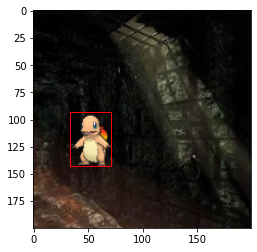

Intersection over union : 0.869


In [50]:
make_single_prediction()

In [40]:
def batch_prediction():
    #Generating batch of images
    X = np.zeros((batch_size,) + image_size, dtype=float)
    Y = np.zeros((batch_size, 5), dtype=float)
    for i in range(batch_size):
        X[i],Y[i] = get_image()
    y_pred = model.predict(X/255.)
    Y[:,0:4] = Y[:,0:4]*dim
    y_pred[:,0:4] = y_pred[:,0:4]*dim
    Y = np.array(np.round(Y), dtype=int)
    y_pred = np.array(np.round(y_pred), dtype=int)

    #Getting confusion matrix and filter Y and y_pred only where object was present and model predicted object too
    cm = confusion_matrix(Y[:,4], y_pred[:,4])
    indexes = ((Y[:,4]==1) & (y_pred[:,4]==1))
    Y, y_pred = Y[indexes,:4], y_pred[indexes,:4]

    #Computing intersection over union over batch of images
    height = np.maximum(np.minimum(Y[:,0]+Y[:,2],y_pred[:,0]+y_pred[:,2])-np.maximum(Y[:,0],y_pred[:,0]),0)
    width = np.maximum(np.minimum(Y[:,1]+Y[:,3],y_pred[:,1]+y_pred[:,3])-np.maximum(Y[:,1],y_pred[:,1]),0)
    common = height*width
    total = Y[:,2]*Y[:,3] + y_pred[:,2]*y_pred[:,3] - common
    iou = common/total
    return cm, iou

Confusion of Matrix on the basis of whether object was present or not
[[22  0]
 [ 0 42]]
Mean of Intersection over union over 64 batch images : 0.851
Standard deviation of Intersection over union over 64 batch images : 0.081


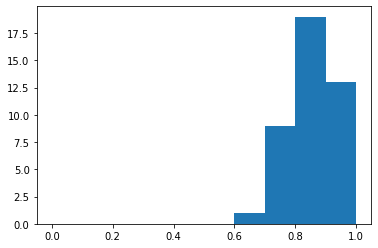

In [42]:
#Distribution of iou on single batch prediction
cm, iou = batch_prediction()
print("Confusion of Matrix on the basis of whether object was present or not")
print(cm)
plt.hist(iou, bins=10, range=(0,1))
print(f'Mean of Intersection over union over 64 batch images : {round(iou.mean(),3)}')
print(f'Standard deviation of Intersection over union over 64 batch images : {round(iou.std(),3)}')

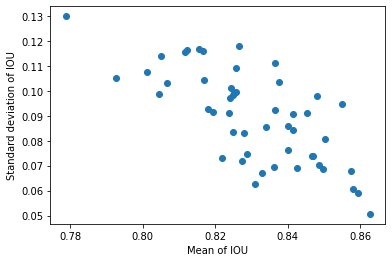

In [45]:
#Plotting how generalize our model is
iou_mean, iou_std = [],[]
for i in range(num_batches):
    _, iou = batch_prediction()
    iou_mean.append(iou.mean())
    iou_std.append(iou.std())
plt.xlabel('Mean of IOU')
plt.ylabel('Standard deviation of IOU')
plt.scatter(iou_mean, iou_std)